In [198]:
import pandas as pd
import sqlite3 as sql
import numpy as np
import re
import string
import os

In [380]:
## join epa vehicle information to adjusted weight information for 2023-2017 years.
epa_df = pd.read_xml("/Users/josheverts/Downloads/vehicles.xml")


## load in data from 2000-2016, stored as .csv files by the epa
path = "/Users/josheverts/Documents/Epa_AdjWeights/Excel"
os.chdir(path)
## data to join with adjusted weights
weight_dfs = []
for file in os.listdir():
    weight_dfs.append(pd.read_excel(file))
# test_data_2023 = pd.read_excel('23-testcar-2022-11-03.xlsx')
# test_data_2022 = pd.read_excel('22-testcar-2023-02-28.xlsx')
# test_data_2021 = pd.read_excel('21-tstcar-2022-04-15.xlsx')
# test_data_2020 = pd.read_excel('20tstcar-2021-03-02.xlsx')
# test_data_2019 = pd.read_excel('19tstcar-2020-10-02.xlsx')
# test_data_2018 = pd.read_excel('18tstcar-2018-10-24.xlsx')
# test_data_2017 = pd.read_excel('17tstcar-2018-05-30.xlsx')

In [ ]:
weight_dfs = [test_data_2023, test_data_2022, test_data_2021,
              test_data_2020, test_data_2019, test_data_2018, test_data_2017]

In [381]:
## load in data from 2000-2016, stored as .csv files by the epa
path = "/Users/josheverts/Documents/Epa_AdjWeights/csv"
os.chdir(path)

In [418]:
epa2000.Make.unique()

array(['Acura', 'BMW', 'Chevrolet', 'Dodge', 'Ferrari', 'Honda', 'Lotus',
       'Mazda', 'Mercedes-Benz', 'Plymouth', 'Porsche', 'Toyota',
       'Aston Martin', 'Audi', 'Jaguar', 'Qvale', 'Bentley', 'Ford',
       'Hyundai', 'Lexus', 'Mitsubishi', 'Pontiac', 'Rolls-Royce', 'Saab',
       'Saturn', 'Subaru', 'Suzuki', 'Volkswagen', 'Volvo', 'Chrysler',
       'Daewoo', 'Infiniti', 'Kia', 'Mercury', 'Nissan', 'Oldsmobile',
       'Buick', 'Cadillac', 'Lincoln', 'GMC', 'Isuzu', 'Jeep',
       'Land Rover'], dtype=object)

In [421]:
epa2000 = epa_df_cleaned[epa_df_cleaned['Year'] == 2000]
epa2000[epa2000['Make'] == 'Toyota']

,VehicleID,Year,MFRCode,Make,Model,Range,RangeHwy,rangeHwyA,atvType,UHighway,UCity,city08,highway08,combE,combinedUF,comb08,trany,cylinders,displ,baseModel
6247,15621,2000,None,Toyota,MR2,0,0.0,0.0,ICE,38.3000,27.9000,22,27,0.0,0.0,24,Manual 5-spd,4.0,1.8,MR2
6362,15725,2000,None,Toyota,Camry Solara Convertible,0,0.0,0.0,ICE,39.0956,25.2733,20,28,0.0,0.0,23,Automatic 4-spd,4.0,2.2,Camry
6363,15726,2000,None,Toyota,Camry Solara Convertible,0,0.0,0.0,ICE,33.4673,20.9000,17,24,0.0,0.0,19,Automatic 4-spd,6.0,3.0,Camry
6364,15727,2000,None,Toyota,Celica,0,0.0,0.0,ICE,44.2000,29.8000,23,31,0.0,0.0,26,Automatic 4-spd,4.0,1.8,Celica
6365,15728,2000,None,Toyota,Celica,0,0.0,0.0,ICE,38.0990,25.6335,20,27,0.0,0.0,23,Automatic 4-spd,4.0,1.8,Celica
6366,15729,2000,None,Toyota,Celica,0,0.0,0.0,ICE,43.2000,30.6000,24,31,0.0,0.0,27,Manual 5-spd,4.0,1.8,Celica
6368,15730,2000,None,Toyota,Celica,0,0.0,0.0,ICE,40.5000,25.7000,20,29,0.0,0.0,23,Manual 6-spd,4.0,1.8,Celica
6488,15839,2000,None,Toyota,Camry Solara,0,0.0,0.0,ICE,39.0956,25.2733,20,28,0.0,0.0,23,Automatic 4-spd,4.0,2.2,Camry
6490,15840,2000,None,Toyota,Camry Solara,0,0.0,0.0,ICE,40.5859,26.0000,21,29,0.0,0.0,24,Manual 5-spd,4.0,2.2,Camry
6491,15841,2000,None,Toyota,Camry Solara,0,0.0,0.0,ICE,34.6852,21.6364,17,25,0.0,0.0,20,Automatic 4-spd,6.0,3.0,Camry


In [387]:
def clean_index_adj_weights(adj_weight_df, yr):
    if yr >= 10: ## 2010 or later
        adj_weight_df_grouped = adj_weight_df.groupby(['Represented Test Veh Make',
                                                       'Represented Test Veh Model', 
                                                       'Veh Mfr Code'], group_keys = False).mean(numeric_only = True)
        adj_weight_df_grouped = adj_weight_df_grouped.reset_index()
        adj_weight_df_grouped = adj_weight_df_grouped.reset_index()
        adj_weight_df_grouped = adj_weight_df_grouped.rename(columns = {'index':'VehicleID'})
        rename_dict = {'Model Year': 'Year', 'Represented Test Veh Make':'Make', 'Veh Mfr Code': 'MFRCode',
                   'Represented Test Veh Model':'Model', 'Equivalent Test Weight (lbs.)':'AdjWeight'}
        epa_adj_weights = adj_weight_df_grouped.rename(rename_dict, axis=1)  
        epa_adj_weights = epa_adj_weights[['VehicleID', 'Year', 'MFRCode', 'Make', 'Model', 'AdjWeight']]
        epa_adj_weights.astype({'Year': 'int32'})
    else:        
        adj_weight_df_grouped = adj_weight_df.groupby(['VI_MFR_NM',
                                                       'CL_NM', 
                                                       'VI_MFR_CD'], group_keys = False).mean(numeric_only = True)
        adj_weight_df_grouped = adj_weight_df_grouped.reset_index()
        adj_weight_df_grouped = adj_weight_df_grouped.reset_index()
        adj_weight_df_grouped = adj_weight_df_grouped.rename(columns = {'index':'VehicleID'})
        rename_dict = {'MDLYR_DT': 'Year', 'VI_MFR_NM':'Make', 'VI_MFR_CD': 'MFRCode',
                   'CL_NM':'Model', 'VC_DSN_ETW_MSR':'AdjWeight'}
        epa_adj_weights = adj_weight_df_grouped.rename(rename_dict, axis=1)  
        epa_adj_weights = epa_adj_weights[['VehicleID', 'Year', 'MFRCode', 'Make', 'Model', 'AdjWeight']]
        epa_adj_weights.astype({'Year': 'int32'})
        
    return epa_adj_weights

def clean_index_vehicle_data(vehicle_df):
    
    ## rename columns of each df
    rename_dict = {'id': 'VehicleID', 'make': 'Make', 'model':'Model', 'mfrCode':'MFRCode', 'range': 'Range',
              'rangeHwy': 'RangeHwy', 'year':'Year'}
    vehicle_df = vehicle_df.rename(rename_dict, axis=1)
    
    ## vehicle atvType are:
    vehicle_df['atvType'].unique()
    ## if None or Diesel, assign ICE
    ## if Hybrid assign HEV
    ## if Plug-in Hybrid assigh PHEV
    ## if FFV assign FCV
    def convert_vals(vals):
        out = []
        for val in vals:
            if pd.isna(val) == True or val == 'Diesel':
                out.append('ICE')
            elif val == 'Hybrid':
                out.append('HEV')
            elif val == 'Plug-in Hybrid':
                out.append('PHEV')
            elif val == 'EV':
                out.append(val)
            elif val == 'FFV':
                out.append('FCV')
            else:
                out.append(None)
        return out
    new_codes = convert_vals(vehicle_df['atvType'])
    vehicle_df['atvType'] = new_codes
    vehicle_df = vehicle_df[['VehicleID', 'Year', 'MFRCode', 'Make', 'Model', 
                             'Range', 'RangeHwy', 'rangeHwyA','atvType', 
                             'UHighway', 'UCity', 'city08', 'highway08', 'combE', 
                             'combinedUF', 'comb08', 'trany', 'cylinders', 'displ', 'baseModel']]
    
    return vehicle_df

def concat_weight_data(weight_dfs, yrs):
    combined = pd.DataFrame()
    for df, yr in zip(weight_dfs, yrs):
        cleaned = clean_index_adj_weights(df, yr)
        combined = pd.concat([combined, cleaned])
    combined['Year'] = combined['Year'].astype('int')
    combined['VehicleID'] = np.arange(0, len(combined)) ## assign new unique ids
    combined = combined.reset_index().drop(['index'], axis = 1)
    return combined
        
    
def vehicle_data_join(vehicle_df, combined_weights):
    vehicle_df = vehicle_df.copy(); combined_weights = combined_weights.copy()
    tempdf = vehicle_df[['VehicleID','Year','Make', 'Model']]
    tempdf2 = vehicle_df[['VehicleID', 'Make', 'Model', 'trany', 'displ', 'cylinders', 'atvType']]
    vehicle_df['Make'] = vehicle_df['Make'].str.lower()
    vehicle_df['baseModel'] = vehicle_df['baseModel'].str.lower()
    vehicle_df['Model'] = vehicle_df['Model'].str.lower()
    combined_weights['Make'] = combined_weights['Make'].str.lower()
    combined_weights['Model'] = combined_weights['Model'].str.lower()
    combined_weights['baseModel'] = [i.split(' ')[0] for i in combined_weights['Model']]
    adj_join = pd.merge(vehicle_df, combined_weights, how='inner', 
                        left_on=['Year', 'Make','baseModel'], right_on = ['Year', 'Make','baseModel'])
    adj_join_g = adj_join.groupby(['VehicleID_x']).agg({'UHighway': np.mean, 'UCity': np.mean, 'city08': np.mean, 
                                                    'Range': np.mean, 'RangeHwy': np.mean, 'rangeHwyA': np.mean,
                                                    'highway08':  np.mean, 'combE': np.mean, 'combinedUF': np.mean, 
                                                    'comb08': np.mean, 'AdjWeight': np.mean})  
    adj_join_g_j = pd.merge(adj_join_g, tempdf2, how = 'inner', left_on='VehicleID_x', right_on='VehicleID')
    adj_join_final_cap = pd.merge(adj_join_g_j, tempdf, how = 'inner', left_on='VehicleID', right_on='VehicleID')
    adj_join_final_cap_drop = adj_join_final_cap.drop(['Make_x', 'Model_x'], axis = 1)
    adj_join_final_cap_drop = adj_join_final_cap_drop.rename({'Make_y': 'Make', 'Model_y': 'Model'}, axis = 1)
#     print(adj_join_final_cap_drop.columns)
    adj_join_final_cap_drop = adj_join_final_cap_drop[~adj_join_final_cap_drop.duplicated(['Year', 'Make', 'Model', 'trany', 'displ', 'cylinders'])]
    cols = adj_join_final_cap_drop.columns.to_list()
    cols = cols[::-1]
    adj_join_final_cap_drop = adj_join_final_cap_drop[cols]
    adj_join_final_cap_drop = adj_join_final_cap_drop.reset_index().drop(['index'], axis = 1)
    
    return adj_join_final_cap_drop


In [350]:
## concatenate .csv files 2000 onwards into one df
yrs = []
csv_dfs = []
for file in os.listdir():
    df = pd.DataFrame()
    # Check whether file is in text format or not
    if file.endswith(".csv"):
        yrs.append(int(file[:2]))
        csv_dfs.append(pd.read_csv(file))
combined_csv0016 = concat_weight_data(csv_dfs, yrs)

<ipython-input-355-bc16651b227d>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  plt.plot(combined_csv0016.groupby('Year').mean()['AdjWeight'])


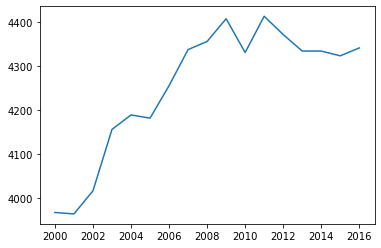

In [355]:
import matplotlib.pyplot as plt
plt.plot(combined_csv0016.groupby('Year').mean()['AdjWeight'])

(array([3.400e+01, 9.600e+01, 3.020e+02, 7.050e+02, 1.027e+03, 1.776e+03,
        1.042e+03, 9.760e+02, 7.130e+02, 6.520e+02, 4.500e+02, 9.800e+01,
        3.880e+02, 1.300e+02, 1.000e+00, 2.300e+01, 0.000e+00, 0.000e+00,
        1.000e+00, 4.000e+00]),
 array([2125.  , 2443.75, 2762.5 , 3081.25, 3400.  , 3718.75, 4037.5 ,
        4356.25, 4675.  , 4993.75, 5312.5 , 5631.25, 5950.  , 6268.75,
        6587.5 , 6906.25, 7225.  , 7543.75, 7862.5 , 8181.25, 8500.  ]),
 <BarContainer object of 20 artists>)

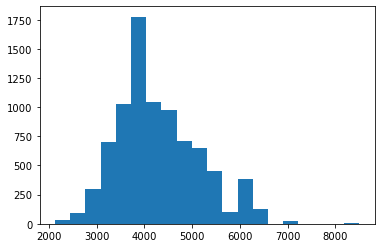

In [358]:
plt.hist(combined_csv0016['AdjWeight'], bins = 20)

In [365]:
## There are some vehicles which are significant weight outliers, we can leave them in for now
## Lincoln navigator 4x4 ext and Chevy g2500 van both above 7000 pounds but research shows ~6000 pounds

In [388]:
## join df to epa df
epa_df_cleaned = clean_index_vehicle_data(epa_df)

In [389]:
joined_data_00_16 = vehicle_data_join(epa_df_cleaned, combined_csv0016)

In [390]:
## concatenate .excel files 2017 onwards into one df
combined_df1723 = concat_weight_data(weight_dfs, np.arange(17,24))

In [398]:
df2000 = pd.read_csv("00tstcar.csv")

In [422]:
df2000['CL_NM'].nunique()

295

In [423]:
epa2000['Model'].nunique()

373

In [407]:
df2000.groupby(['OV_ID', 'CL_NM']).count()

,,MDLYR_DT,VI_MFR_CD,VI_MFR_NM,GBE_INDX_NUM,VC_CNFG_NUM,CLS_TYP_CD,GBE_CID_MSR,GBE_PLC_IND_CD,VC_RTD_HP_MSR,ECS_CD,...,TPF_DYN_TRK_A_MSR,TPF_DYN_TRK_B_MSR,TPF_DYN_TRK_C_MSR,TPF_EDYN_TRK_A_MSR,TPF_EDYN_TRK_B_MSR,TPF_EDYN_TRK_C_MSR,ENG_CD,EF_ID,VC_CYL_CNT,TPF_MFR_CSTDN_MSR
OV_ID,CL_NM,,,,,,,,,,,,,,,,,,,,,
00-JS1,GS 300/GS 400,6,6,6,6,6,6,6,6,6,6,...,0,0,0,0,0,0,6,6,6,6
00-JZ1,SC 300/SC 400,5,5,5,5,5,5,5,5,5,5,...,0,0,0,0,0,0,5,5,5,5
00-MX1,AVALON,2,2,2,2,2,2,2,2,2,2,...,0,0,0,0,0,0,2,2,2,2
00-NCP1,ECHO,3,3,3,3,3,3,3,3,3,3,...,0,0,0,0,0,0,3,3,3,3
00-NCP2,ECHO,2,2,2,2,2,2,2,2,2,2,...,0,0,0,0,0,0,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YCF-HM82,IMPREZA AWD,2,2,2,2,2,2,2,2,2,2,...,0,0,0,0,0,0,2,2,2,2
YCF-HN69,FORESTER AWD,4,4,4,4,4,4,4,4,4,4,...,0,0,0,0,0,0,4,4,4,4
YCF-HN89,FORESTER AWD,4,4,4,4,4,4,4,4,4,4,...,0,0,0,0,0,0,4,4,4,4


In [391]:
joined_data_17_23 = vehicle_data_join(epa_df_cleaned, combined_df1723)

In [392]:
## combine joined dataframes to create years 2010-2023
joined_data_00_23 = pd.concat([joined_data_00_16, joined_data_17_23])
joined_data_00_23['VehicleID'] = np.arange(0, len(joined_data_00_23)) ## assign new unique ids
joined_data_00_23 = joined_data_00_23.reset_index().drop(['index'], axis = 1)

In [424]:
joined_data_00_23.groupby('Year').count()

,Model,Make,atvType,cylinders,displ,trany,VehicleID,AdjWeight,comb08,combinedUF,combE,highway08,rangeHwyA,RangeHwy,Range,city08,UCity,UHighway
Year,,,,,,,,,,,,,,,,,,
2000,183,183,181,182,182,182,183,183,183,183,183,183,183,183,183,183,183,183
2001,193,193,191,192,192,192,193,193,193,193,193,193,193,193,193,193,193,193
2002,213,213,212,212,212,212,213,213,213,213,213,213,213,213,213,213,213,213
2003,210,210,209,209,209,209,210,210,210,210,210,210,210,210,210,210,210,210
2004,233,233,232,233,233,233,233,233,233,233,233,233,233,233,233,233,233,233
2005,243,243,242,243,243,243,243,243,243,243,243,243,243,243,243,243,243,243
2006,221,221,220,221,221,221,221,221,221,221,221,221,221,221,221,221,221,221
2007,239,239,238,239,239,239,239,239,239,239,239,239,239,239,239,239,239,239
2008,260,260,259,260,260,260,260,260,260,260,260,260,260,260,260,260,260,260


In [425]:
joined_data_00_23.to_csv("adj_weight_data_join_2000-2023.csv", index = False)

In [321]:
row = pd.read_csv("09tstcar.csv").iloc[1200]
cols = pd.read_csv("09tstcar.csv").columns
for val, name in zip(row, cols):
    print(str(name) + ": " + str(val))


MDLYR_DT: 2009
VI_MFR_CD: 200
VI_MFR_NM: MERCEDES BENZ
GBE_INDX_NUM: 37
OV_ID: C209E35-Z6020
VC_CNFG_NUM: 3
CL_NM: CLK350
CLS_TYP_CD: C
GBE_CID_MSR: 213
GBE_PLC_IND_CD: N
VC_RTD_HP_MSR: 268
ECS_CD: nan
ECS_CD_0: nan
ECS_CD_1: nan
ECS_CD_2: nan
ECS_CD_3: nan
EVCS_CD: 102.0
TRNS: L7
DRV_SYS_CD: R
TOD_CD: 2
VC_DSN_ETW_MSR: 3875
VC_CMPRSN_RAT_MSR: 10.5
VC_AXLE_RAT_MSR: 2.82
VC_NV_RAT_MSR: 29.1
TPF_ACHP_IND_CD: N
TPF_DYNO_HP_MSR: nan
SIL_CD: 1
TST_PRC_CD: 3
TST_PRPS_CD: 31
TST_NUM_ID: 1069896
VEH_FL_TYP_CD: 61
CH_CD: H
AVRG_CD: 1
GT_WT_MSR: 1.0
CMYT_HC_FE_MSR: 0.012
CMYT_CO_FE_MSR: 0.13
CMYT_CO2_FE_MSR: 250.0
CMYT_NOX_MSR: nan
CMYT_PM_MSR: nan
GT_RND_ADJ_QTY: 35.5
TPF_DYN_TRK_A_MSR: 49.108
TPF_DYN_TRK_B_MSR: 0.35988
TPF_DYN_TRK_C_MSR: 0.012664
TPF_EDYN_TRK_A_MSR: 29.697
TPF_EDYN_TRK_B_MSR: -0.3034
TPF_EDYN_TRK_C_MSR: 0.018504
ENG_CD: M272-35
EF_ID: 9MBXV03.5BN4
VC_CYL_CNT: 6
TPF_MFR_CSTDN_MSR: 18.15


In [186]:
epa_df = clean_index_vehicle_data(epa_df)

In [315]:
epa_df_cleaned[epa_df_cleaned['Year'] == 2000]

,VehicleID,Year,MFRCode,Make,Model,Range,RangeHwy,rangeHwyA,atvType,UHighway,UCity,city08U,highway08U,combE,combinedUF,comb08,trany,cylinders,displ,baseModel
6210,15589,2000,None,Acura,NSX,0,0.0,0.0,ICE,30.1499,19.2343,0.0,0.0,0.0,0.0,18,Automatic 4-spd,6.0,3.0,NSX
6212,15590,2000,None,Acura,NSX,0,0.0,0.0,ICE,30.4000,19.0000,0.0,0.0,0.0,0.0,18,Manual 6-spd,6.0,3.2,NSX
6213,15591,2000,None,BMW,M Coupe,0,0.0,0.0,ICE,32.7000,21.1000,0.0,0.0,0.0,0.0,19,Manual 5-spd,6.0,3.2,M
6214,15592,2000,None,BMW,Z3 Coupe,0,0.0,0.0,ICE,33.6000,20.9000,0.0,0.0,0.0,0.0,19,Automatic 4-spd,6.0,2.8,Z3
6215,15593,2000,None,BMW,Z3 Coupe,0,0.0,0.0,ICE,32.8870,21.0220,0.0,0.0,0.0,0.0,19,Manual 5-spd,6.0,2.8,Z3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7139,16424,2000,None,Toyota,RAV4 EV,88,0.0,0.0,EV,91.0811,116.2069,0.0,0.0,47.0,0.0,72,None,NaN,NaN,RAV4
21121,29208,2000,None,Ford,Crown Victoria Police,0,0.0,0.0,ICE,27.4499,17.5499,0.0,0.0,0.0,0.0,16,Automatic 4-spd,8.0,4.6,Crown Victoria
21573,29626,2000,None,Chevrolet,Tahoe 1500 2WD,0,0.0,0.0,ICE,25.1000,16.5000,0.0,0.0,0.0,0.0,15,Automatic 4-spd,8.0,5.3,Tahoe
23017,30966,2000,None,Ford,Ranger Pickup 2WD,50,0.0,0.0,EV,76.5909,88.6842,0.0,0.0,58.0,0.0,58,Automatic (A1),NaN,NaN,Ranger


In [187]:
joined_data = vehicle_data_join(epa_df, weight_dfs)

In [189]:
joined_data.to_csv("adj_weight_data_join_2017-2023.csv", index = False)